# Google Stock Price Prediction

We will try the closing stock price of Google. A RNN, more specifically an LSTM RNN will be used to predict the stock price.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

C:\Users\Siya\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Siya\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Siya\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Siya\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (

## Load Data and Preprocess it

There are two data sets present for this project:
1. A Training Set
2. A Test Set

The model will be trained on the training set. Once fully trained, the model will be tested on the test set and the results will be visulaised.
The model will be trained on 5 years of data (2012/2016), with 1258 data entries. The data has the following columns:
1. Date
2. Open Price
3. High
4. Low
5. Close Price
6. Volume

In [2]:
data_set = pd.read_csv('Google_Stock_Price_Train.csv', delimiter =';')
data_set['Date']=pd.to_datetime(data_set['Date'], infer_datetime_format=True)

In [3]:
data_set.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
1,2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2,2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
3,2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
4,2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
Date      1258 non-null datetime64[ns]
Open      1258 non-null float64
High      1258 non-null float64
Low       1258 non-null float64
Close     1258 non-null float64
Volume    1258 non-null object
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 59.1+ KB


We want the closing price only, over the 5 years,in order to train the network. However will do some EDA on the data.

## EDA (Exploratory Data Analysis)

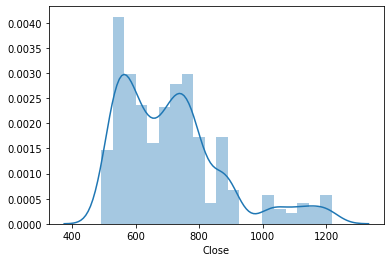

In [5]:
sns.distplot(data_set['Close'])

From the above plot, it is evident that the mean closing price is between 500 and 600, then again a spike is evident at around 700 approximately. After conducting some research, it was noted that the previous stock prices had no impact on future stock prices. Meaning,the future stock price is independent of past values.

In [6]:
data_set.describe()

,Open,High,Low,Close
count,1258.000000,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409,712.669666
std,151.904442,153.008811,150.552807,164.752591
min,279.120000,281.210000,277.220000,491.200000
25%,404.115000,406.765000,401.765000,576.740000
50%,537.470000,540.750000,532.990000,695.675000
75%,654.922500,662.587500,644.800000,782.105000
max,816.680000,816.680000,805.140000,1216.830000


The describe method, from Pandas, also gives similar results to the distribution of the close price.
This was conducted to see some trends in the closing price.

C:\Users\Siya\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


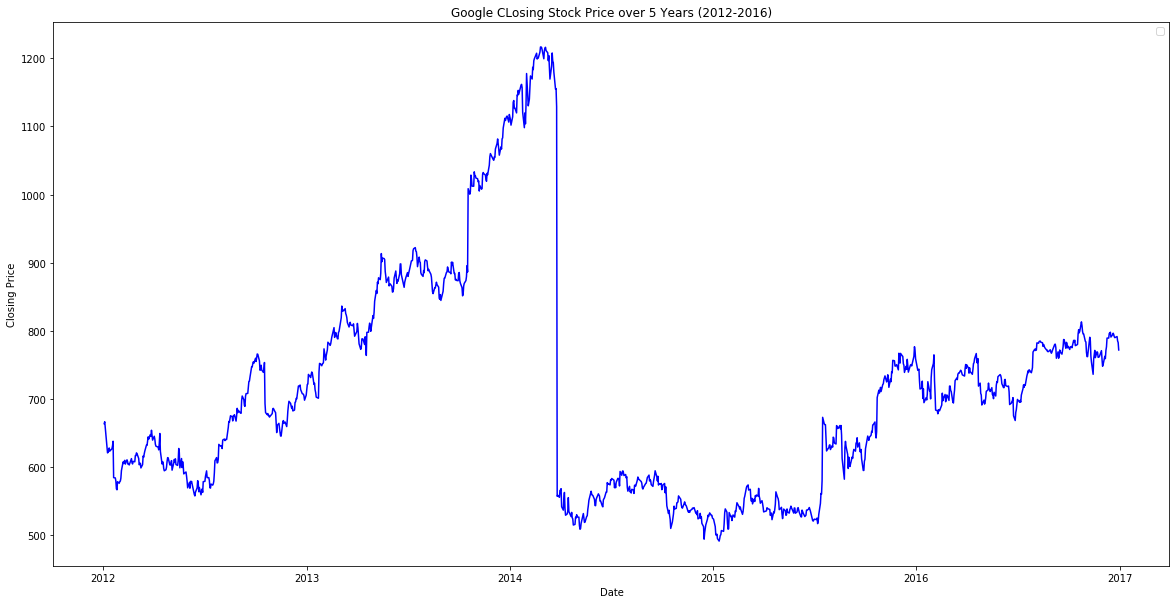

In [7]:
# Create a line plot for the Close price as a function of time
plt.figure(figsize=(20,10))
plt.plot(data_set['Date'], data_set['Close'], color = 'blue')
plt.title('Google CLosing Stock Price over 5 Years (2012-2016)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

From the above plot, we see a general overview of the Closing Price over 5 Years. Some interesting observations are the spike that occured at the beginning of 2014, which caused the price to soar to a value of 1216 US dollars. Thereafter a massive dip occured. There was a general uptrend into 2015 until 2016, which consisted of minor down trends.

## Preprocess the data

We will need to take Closing price column from the data frame and convert it into a 1-D array. Because our neural net, only takes arrays

In [8]:
train_set = data_set.iloc[:, 4:5].values
print(train_set)

[[663.59]
 [666.45]
 [657.21]
 ...
 [785.05]
 [782.79]
 [771.82]]


In [9]:
train_set.shape

(1258, 1)

We have what we want now, further preprocessing. We need to conduct Normalisation Feature Scaling (getting values between 0 and 1).

In [10]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0,1))

train_set_scaled = sc.fit_transform(train_set)
train_set_scaled.shape

(1258, 1)

We now need to put the data structure in to a form with 60 timesteps. Recall, we are working with an RNN(LSTM), which are used for Time Series problems. The 60 timesteps, the network has to remember, in oder to predict the following value at time = t+1.
So the RNN will remember all the stock price values, from t = 0 until t = 60, in order to predict the t=61 value, and this will continue, until we parse through the whole training set. This is a very important step. So for our data, 60 timesteps = 3 months. So the RNN, will remember 3 months prior. This because, since a financial week has 5 working days, a month has 20 working days. The 60 timesteps, will be the memory of the neural net.

In [11]:
# Initialise the input and the output

X_train = [] # Input into the LSTM layer (60 previous stock prices)

y_train = [] # The output, which will be the next stock price.


for i in range(120, 1258): # i is the index of the stock price observation, we have 1257 observations.
    X_train.append(train_set_scaled[i-120:i, 0]) # so the training set now will be a 2D matrix 
    y_train.append(train_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape
y_train.shape

(1138,)

In [12]:
print(X_train.shape[1])
print(X_train.shape[0])

120
1138


In [13]:
# We need to reshape X_train, into a Tensor (3D array)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_train.shape[0] is the batch_size = 1198
#X_train.shape[1] is the no of timesteps = 60
#1 - the indicator we are using, which is the close price
#The above, are the dimensions that go into an RNN, based on Keras documentation.

In [14]:
print(X_train.shape)

(1138, 120, 1)


Now our training set is ready, it is in the right format: 3D array. 

## Build the Recurrent Neural Network

In [15]:
# Import libraries
from keras.models import Sequential # Our NN will be a sequence of layers
from keras.layers import Dense # For our output layers
from keras.layers import LSTM # For the stacked LSTM layer which our NN memory
from keras.layers import Dropout # For regularization to avoid overfitting

Using TensorFlow backend.


### Initialise The RNN

In [16]:
regressor = Sequential()

### First LSTM Layer

In [17]:
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) # Prevent overfitting
#X_train = 60 timesteps, 1 =close price
# return_sequence is used for when we will another LSTM layer

Instructions for updating:
Colocations handled automatically by placer.


### Second LSTM Layer

In [18]:
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

### Third LSTM Layer

In [19]:
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

### Fourth LSTM Layer

In [20]:
regressor.add(LSTM(units = 100))
regressor.add(Dropout(0.2))
# We wont need return_sequence this time because, this is our last LSTM layer.

### Output Layer

In [21]:
regressor.add(Dense(units = 1))
regressor.add(Dropout(0.2))

### Compile the RNN

In [22]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fit the RNN to the training data

In [23]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1138/1138 [==============================] - 24s 21ms/step - loss: 0.0561
Epoch 2/100
1138/1138 [==============================] - 22s 20ms/step - loss: 0.0425
Epoch 3/100
1138/1138 [==============================] - 22s 20ms/step - loss: 0.0385
Epoch 4/100
1138/1138 [==============================] - 22s 19ms/step - loss: 0.0358
Epoch 5/100
1138/1138 [==============================] - 22s 20ms/step - loss: 0.0451
Epoch 6/100
1138/1138 [==============================] - 23s 20ms/step - loss: 0.0272
Epoch 7/100
1138/1138 [==============================] - 23s 20ms/step - loss: 0.0352
Epoch 8/100
1138/1138 [==============================] - 24s 21ms/step - loss: 0.0402
Epoch 9/100
1138/1138 [==============================] - 22s 20ms/step - loss: 0.0396
Epoch 10/100
1138/1138 [==============================] - 23s 21ms/step - loss: 0.0398
Epoch 11/100
1138/1138 [==============================] - 23s 20ms/step - loss: 0.0380
Epoc

1138/1138 [==============================] - 24s 21ms/step - loss: 0.0278
Epoch 93/100
1138/1138 [==============================] - 22s 20ms/step - loss: 0.0297
Epoch 94/100
1138/1138 [==============================] - 21s 19ms/step - loss: 0.0314
Epoch 95/100
1138/1138 [==============================] - 22s 19ms/step - loss: 0.0348
Epoch 96/100
1138/1138 [==============================] - 22s 20ms/step - loss: 0.0293
Epoch 97/100
1138/1138 [==============================] - 22s 19ms/step - loss: 0.0334
Epoch 98/100
1138/1138 [==============================] - 22s 20ms/step - loss: 0.0296
Epoch 99/100
1138/1138 [==============================] - 21s 18ms/step - loss: 0.0311
Epoch 100/100
1138/1138 [==============================] - 22s 19ms/step - loss: 0.0299


## Test the RNN and Visualise the results

We will test the model,on the test data, which consists of data entries from the January 2017. Which consists of 20 entries.

In [24]:
test_set = pd.read_csv('Google_Stock_Price_Test.csv')

In [25]:
test_set.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [26]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
Date      20 non-null object
Open      20 non-null float64
High      20 non-null float64
Low       20 non-null float64
Close     20 non-null float64
Volume    20 non-null object
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [27]:
real_stock_price = test_set.iloc[:, 4:5].values # The closing price of January 2017

The model is an RNN, so therefore, it needs memory, in order to properly predict the stock price. Therefore, we wil have to join the test and training sets and make sure, that the training set will serve as the memory of the LSTM network. The RNN will still recall 60 timesteps prior to the current prediction.

In [28]:
#Concatinate the training and test Closing columns vertically.
#The test set CLosing price values will be added underneath the training values.
data = pd.concat((data_set['Close'], test_set['Close']), axis = 0)
print(len(data))
print(len(test_set))

1278
20


In [34]:
# Get the inputs
inputs = data[len(data) - len(test_set) - 120:].values # We want to take the memory (60 timesteps) and test set as inputs to the RNN
inputs = inputs.reshape(-1,1) # Re shape to an array
inputs = sc.transform(inputs) # Transform the inputs to be within (0, 1)

In [35]:
# Get the test set in a structure with 60 timesteps 
X_test = []

for i in range(120, 140): # Recall we want 60 timesteps and we only have 20 entries for the test set
    X_test.append(inputs[i-120:i, 0])
    
X_test = np.array(X_test)
X_test.shape

(20, 120)

In [36]:
# We now have to give the test set 3 dimensions (Tensor Form)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(20, 120, 1)

In [37]:
# Now we can test the model
prediction = regressor.predict(X_test)
prediction = sc.inverse_transform(prediction)

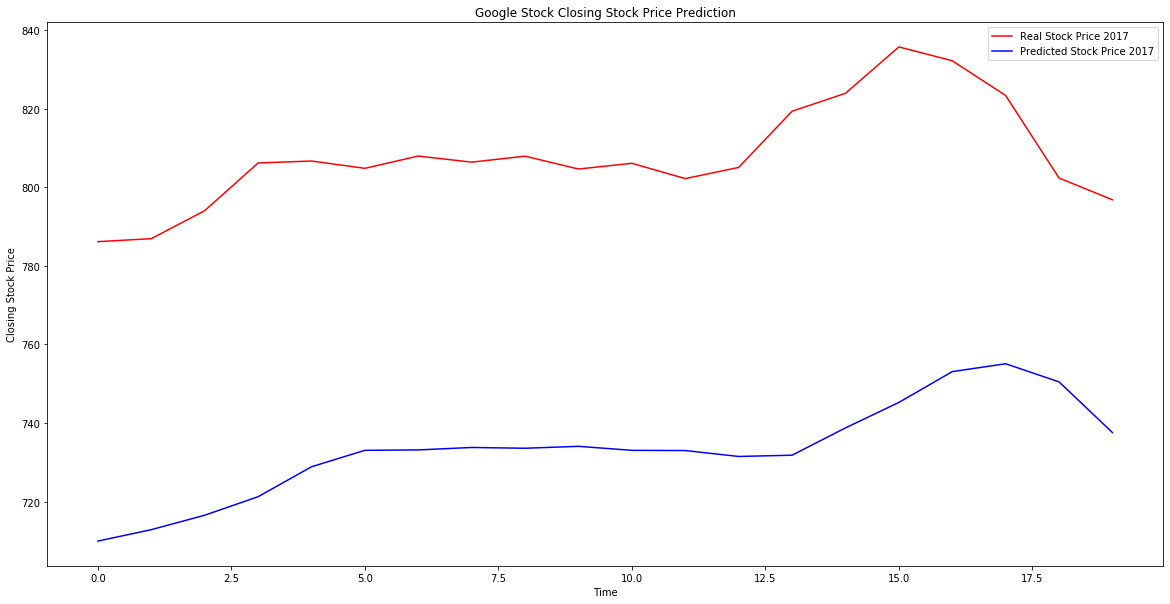

In [38]:
### Visulaise the Results
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price 2017')
plt.plot(prediction, color = 'blue', label = 'Predicted Stock Price 2017')
plt.xlabel('Time')
plt.ylabel('Closing Stock Price')
plt.legend()
plt.title('Google Stock Closing Stock Price Prediction')
plt.show()